## Do imports

In [130]:
# MDAnalysis tools
import MDAnalysis as mda
from MDAnalysis.analysis import contacts

# To view the trajs on notebook
import nglview as nv
from ipywidgets import interact, fixed

# Data processing
import pandas as pd
import numpy as np

# Plot & System tools
import matplotlib as mpl
import matplotlib.pyplot as plt
from  matplotlib.colors import ListedColormap, NoNorm, BoundaryNorm, CSS4_COLORS
import seaborn as sns

# Remove warnings
import warnings
warnings.filterwarnings('ignore')

import os

In [131]:
!jupyter-nbextension enable nglview --py --sys-prefix
!jupyter-nbextension enable --py --sys-prefix widgetsnbextension

Enabling notebook extension nglview-js-widgets/extension...
      - Validating: OK
Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


# Functions

In [132]:
def change_representation(view, representation):
    view.clear()
    view.representations = [
        {"type": representation,
         "params": {"sele":"367-372","color":"red","radiusType":"vdW"}},
        {"type": "cartoon","aspectRatio":"10",
         "params": {"sele":"40-337","color":"cyan","radiusType":"vdW","opacity":"0.5"}}
    ]
    
    view.control.rotate(
    mda.lib.transformations.quaternion_from_euler(
        -np.pi/2, np.pi/2, np.pi/13, 'rzyz').tolist())
    view.camera = 'orthographic'
    return view

def show_residues_around(view, component_index=0, selection="ligand", radius=6.0):
    js = (
        f"""
        var system = this.stage.compList[{component_index}];
        var prevSele = system.selection.string;
        system.setSelection("{selection}");
        var around = system.structure.getAtomSetWithinSelection(system.selection, {radius});
        """
        """
        var around_complete = system.structure.getAtomSetWithinGroup(around);
        system.addRepresentation("ball+stick", {sele: around_complete.toSeleString()});
        system.setSelection(prevSele)
        """
    )
    view._execute_js_code(js)
    
# Function to see motion along a pca
# Inputs: PC index, frame_i, frame_j , selection
def get_motion(pindex=0, framei=0, framej=100, sel='name BB' ):
    getpc =  mypca.p_components[:, pindex]
    trans =  pcspace[:, pindex]
    projected = np.outer(trans, getpc ) + mypca.mean.flatten()
    
    backbone = U.select_atoms(sel)
    proj = mda.Merge(backbone)
    coordinates = projected.reshape(len(trans), -1, 3)
    proj.load_new(coordinates[ [framei,framej],: ], order="fac")
    
    return proj

# Set the directory for the simulation and define Input  files (finp)

In [133]:
path='/Users/kansoali/Desktop/cg_simulations'

os.chdir(path+os.sep+'new_simu1')

finp_ref  = 'system.gro'                  # reference
finp_trj  = 'step7_production.pbc.xtc'    # traj

# We load
    1. trajectory
    2. reference structure file

In [134]:
#U   = mda.Universe(finp_ref, finp_trj)       #Open Traj
ref = mda.Universe(finp_ref)                 #Open ref file 

#display(U.trajectory)

# Trajectory Alignment (skip if already done)
    - We align the traj (& retain `in memory`) using atom group `receptor`.

In [ ]:
# Align traj to reference using atmgroup receptor
align.AlignTraj( U, ref, select=receptor , in_memory=True).run()
'Done Boss'

In [ ]:
# save aligned traj
system_aligned = U.select_atoms("all")
with mda.Writer("traj_aligned.trr", system_aligned.n_atoms) as W:
    for ts in U.trajectory:
        W.write(system_aligned)

# Load the aligned trajectory

In [135]:
finp_trj  = 'traj_aligned.trr'  
U   = mda.Universe(finp_ref, finp_trj,in_memory=True)   

# Visualize the protein

In [12]:
# Select full protein and domains

full = 'protein'

backbone = "name BB"
BB=U.select_atoms(backbone)

receptor = 'resid 40-337'
rec =U.select_atoms(receptor)

peptide = 'resid 367-372'
pep = U.select_atoms(peptide)

In [13]:
view = nv.show_mdanalysis(U, gui=False)

representations= ["cartoon","backbone", "ball+stick"] #for the peptide

#representations = ["cartoon","backbone", "ball+stick"] #for the peptide    
interact(change_representation,view=fixed(view), representation=representations) 

#view.add_representation("ball+stick",color='orange',selection="name PO4",aspectRatio=7,opacity="0.4" )

interactive(children=(Dropdown(description='representation', options=('cartoon', 'backbone', 'ball+stick'), va…

<function __main__.change_representation(view, representation)>

In [9]:
#v_small_membrane = nv.show_mdanalysis(U.select_atoms('name PO4'))
#v_small_membrane.add_representation("ball+stick", aspectRatio=7)
#v_small_membrane

# Contacts

In [ ]:
bs = U.select_atoms("protein and around 4 group peptide", peptide=pep, updating=True)

bs_atoms = []

for ts in U.trajectory:
    bs_atoms.append(len(bs.atoms))

#print(bs_atoms)

Suggested cutoff distances for different simulations

    For all-atom simulations, cutoff = 4.5 Å
    For coarse-grained simulations, cutoff = 6.0 Å


In [ ]:
ca1 = contacts.Contacts(U, select=(receptor, peptide),
                        refgroup=(rec, pep), radius=6.0)

ca1.run()

# print number of averave contacts
average_contacts = np.mean(ca1.timeseries[:, 1])
print('average contacts = {}'.format(average_contacts))

# plot time series q(t)
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(ca1.timeseries[:, 0], ca1.timeseries[:, 1])
ax.set(xlabel='frame', ylabel='fraction of native contacts',
       title='Native Contacts, average = {:.2f}'.format(average_contacts))
fig.show()

In [ ]:
n_ref = ca1.initial_contacts[0].sum()
print('There are {} contacts in the reference.'.format(n_ref))

# Clustering

In [ ]:
#!echo 23 0 | gmx cluster -f traj_aligned.trr -s step7_production.tpr -cl clusters.xtc -cutoff 0.3 -method gromos -wcl 10 -n index.ndx -nofit -clid clusters.xvg -sz clusters_size.xvg

check the trajectories clusters.xtc (contains all the clusters and each cluster has a number of frames(see bellow))

In [137]:
nb_simu=3
path='/Users/kansoali/Desktop/cg_simulations'

finp_ref=str(path+os.sep+'new_simu'+str(nb_simu)+os.sep+'system.gro')
finp_trj=str(path+os.sep+'new_simu'+str(nb_simu)+os.sep+'clusters.xtc')

In [138]:
C = mda.Universe(finp_ref,finp_trj) 
cluster = nv.show_mdanalysis(C, gui=False)

change_representation(cluster,'cartoon')

NGLWidget(max_frame=101)

The population in each cluster (here I am showing just the 5 first clusters of each simulation)

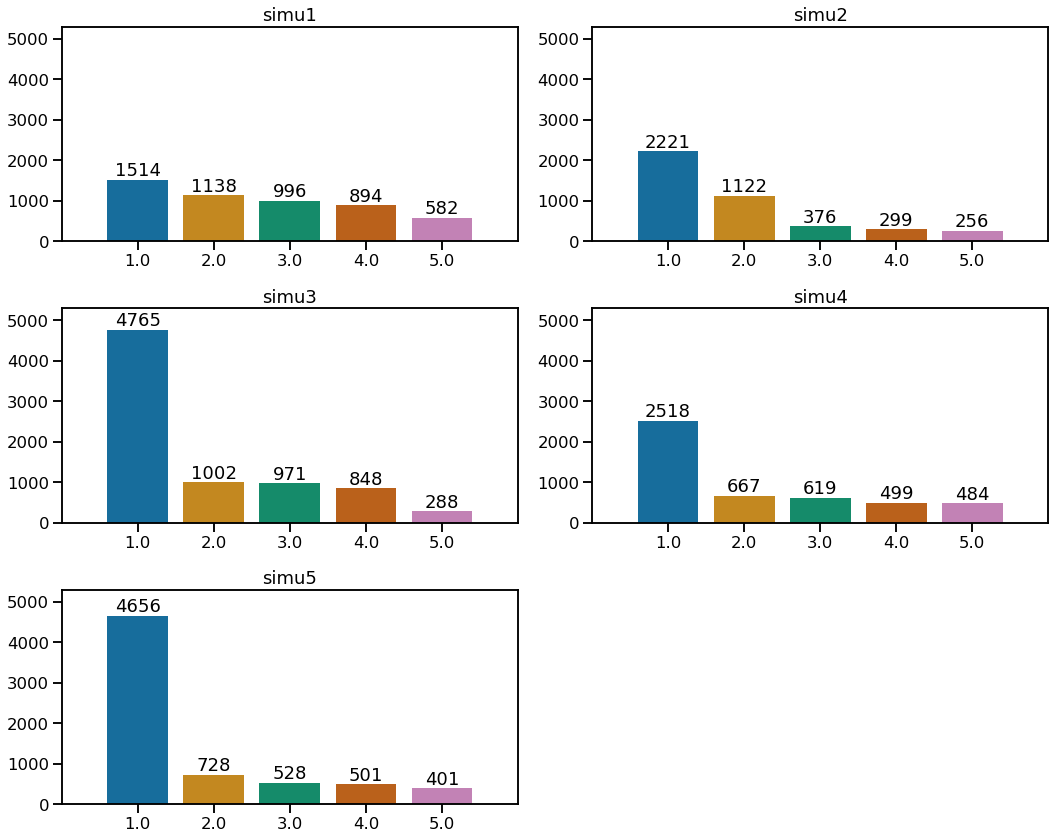

In [165]:
sns.set_context('talk')
sns.set_palette('colorblind')

nb_simu=list(range(1,6))

plt.figure(figsize=(15, 12))
plt.subplots_adjust(hspace=0.5)


for cnt,nb_simu in enumerate(nb_simu):
    path='/Users/kansoali/Desktop/cg_simulations'
    os.chdir(path+os.sep+'new_simu'+str(nb_simu))
   
    x,y = np.loadtxt("clusters_size.xvg",comments=['#','@'],unpack=True) 

    ax = plt.subplot(3,2, cnt + 1)

    v = sns.barplot(x[:5],y[:5])       ###change here if you want to see more clusters
    plt.title('simu'+str(nb_simu))
    plt.xlim(-1,5)
    plt.ylim(0,5300)
    for i in v.containers:
        v.bar_label(i,)
        
plt.tight_layout()

In [358]:
sns.set_context('talk')
sns.set_palette('colorblind')

nb_simu=list(range(1,6))

df = pd.DataFrame(columns=(['x','y','sim']),index = [x for x in range(25)])

counter = 0

for cnt,nb_simu in enumerate(nb_simu):
    path='/Users/kansoali/Desktop/cg_simulations'
    os.chdir(path+os.sep+'new_simu'+str(nb_simu))
   
    x,y = np.loadtxt("clusters_size.xvg",comments=['#','@'],unpack=True)
    for count,i in enumerate(x[:5]):
        
        df.iloc[counter]['x'] = int(i)
        df.iloc[counter]['y'] = int(y[count])
        df.iloc[counter]['sim'] = 'simu' +str(cnt+1)
        
        counter+=1

<AxesSubplot:xlabel='sim', ylabel='y'>

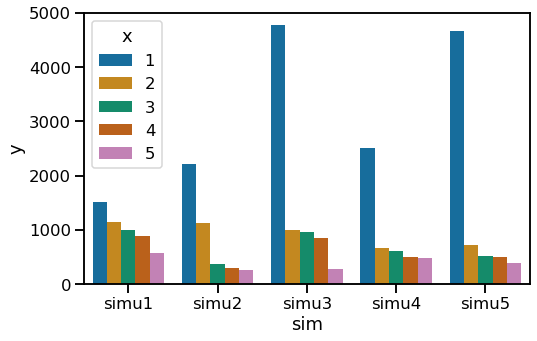

In [281]:
sns.set_context('talk')

fig,ax = plt.subplots(figsize=(8,5))

sns.barplot(data=df,x='sim',y='y',hue='x',ax=ax,palette='colorblind')

Write a new traj with the first 10 clusters of each simulation and save in a new folder

In [283]:
os.chdir(path)

outputFolder = 'clusters_20frames'
if not os.path.exists(outputFolder):
    os.mkdir(outputFolder)

os.chdir(path+os.sep+outputFolder)
c=[]

for nb_simu in range(1,6):
    finp_trj=str(path+os.sep+'new_simu'+str(nb_simu)+os.sep+'clusters.xtc')
    c.append(mda.Universe(finp_ref,finp_trj))
    
for cnt, X in enumerate(c):
    clusters = X.select_atoms("all")
    with mda.Writer("clusters_simu"+str(cnt+1)+".trr", clusters.n_atoms) as W:
        for ts in X.trajectory[:5]:
            W.write(clusters)

In [209]:
nb_simu=2

C = mda.Universe(finp_ref, 'clusters_simu'+str(nb_simu)+'.trr')
clu=nv.show_mdanalysis(C)

change_representation(clu,'cartoon')
show_residues_around(clu,selection="367-372",radius=3)
clu

NGLWidget(max_frame=4)

# Concatenate

In [284]:
l = ['clusters_simu' +str(x)+'.trr' for x in range(1,6)]
print(l)
test = mda.Universe(finp_ref,l)
clust = test.select_atoms("all")
with mda.Writer("concatenated_md.trr", clust.n_atoms) as W:
    for ts in test.trajectory:
        W.write(clust)

['clusters_simu1.trr', 'clusters_simu2.trr', 'clusters_simu3.trr', 'clusters_simu4.trr', 'clusters_simu5.trr']


In [213]:
path='/Users/kansoali/Desktop/cg_simulations'
outputFolder = 'clusters_20frames'
os.chdir(path+os.sep+outputFolder)

CO = mda.Universe(finp_ref,'concatenated_md.trr', in_memory=True) 
conca=nv.show_mdanalysis(CO)
change_representation(conca,'cartoon')

NGLWidget(max_frame=24)

# RMSD Analysis

- HOWTO
    1. We first fit the traj using the receptor atoms (group `receptor`).
    2. After fitting, we obtain RMSD for different domains without superimposition.
    3. We create a dataframe (`df_rms`) as the container for RMSD data.
    4. In the dataframe, we use `Frame` signature as index (row labels).

In [31]:
from MDAnalysis.analysis import rms, diffusionmap
from MDAnalysis.analysis.rms import RMSD
import plotly.express as px

In [32]:
fout_rms   = 'RMSD.csv'  # rmsd output file
ref = mda.Universe(finp_ref) 

receptor = 'name BB and (resid 40-337)'
rec =CO.select_atoms(receptor)

peptide = 'resid 367-372'
pep = CO.select_atoms(peptide)

In [33]:
R = RMSD(CO,
        ref,  # reference universe or atomgroup
        select= receptor,  # group to superimpose and calculate RMSD
        groupselections=[peptide])  # groups for domain RMSDs
R.run()
display('Done Boss', R.rmsd.shape)

'Done Boss'

(25, 4)

In [34]:
cols = ['Frame','Time', 'receptor','peptide' ]
df_rms = pd.DataFrame(R.rmsd, columns=cols)

df_rms.drop('Time',axis=1,inplace=True)      #Drop Frame column, we retain only Time

#df_rms['Time' ] = df_rms.Time* 0.001          #Convert time to ns
#df_rms.set_index('Time',inplace=True)         #Set Time as index (row labels)
#df_rms

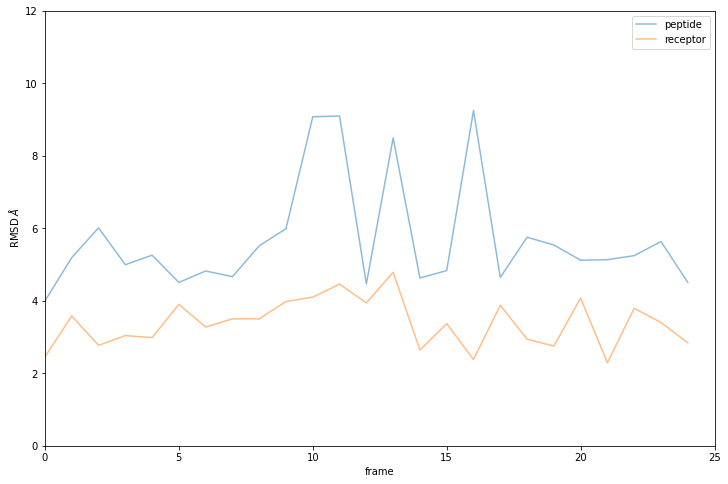

In [35]:
# Lets do time evolution of RMSD
fig = plt.figure(figsize=(12, 8))

df_rms.peptide.plot(alpha=0.5)
df_rms.receptor.plot(alpha=0.5)

plt.xlim( [0,25])
plt.ylim( [0,12])
plt.xlabel('frame')
plt.ylabel( ' RMSD $\AA$')
plt.legend()
plt.show()

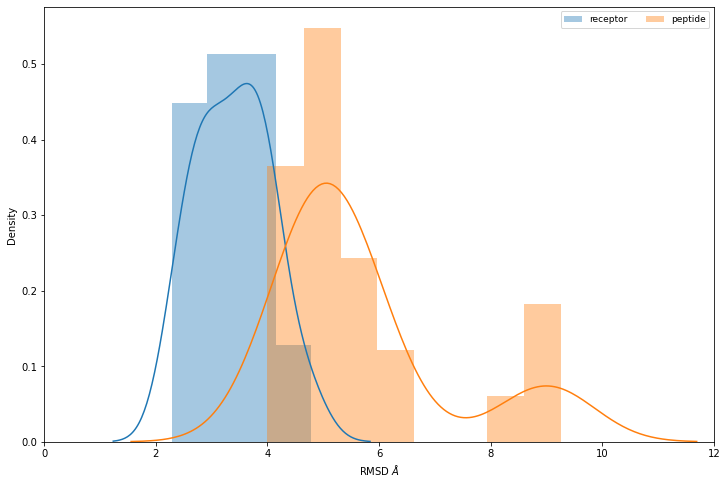

In [36]:
# Lets see the distribution of RMSD values
fig, ax = plt.subplots( figsize=(12,8) )
sns.distplot(df_rms.receptor,hist=True,label='receptor',ax=ax)
sns.distplot(df_rms.peptide,hist=True,label='peptide',ax=ax)

plt.legend(ncol=2,fontsize=9)
plt.xlabel('RMSD $\AA$')
plt.xlim( [0,12])
plt.show()

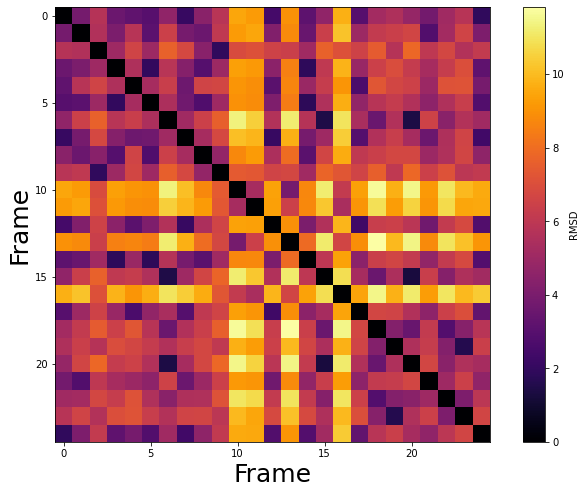

In [38]:
matrix = diffusionmap.DistanceMatrix(CO, select=peptide).run()
matrix.dist_matrix.shape

fig = plt.figure(figsize=(12, 8))
plt.imshow(matrix.dist_matrix, cmap='inferno',interpolation='nearest')
plt.xlabel('Frame',fontsize='25')
plt.ylabel('Frame',fontsize='25')
plt.colorbar(label=r'RMSD')
plt.show()

In [39]:
mat=matrix.dist_matrix
mat[mat<3]=0

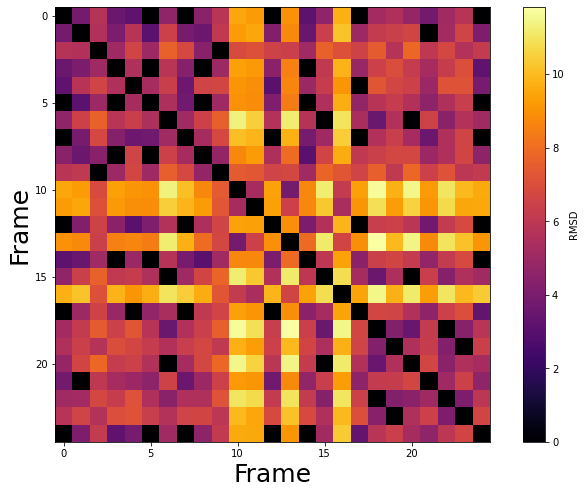

In [40]:
labels=['simu1','simu2','simu3','simu4','simu5']
fig = plt.figure(figsize=(12, 8))
plt.imshow(matrix.dist_matrix, cmap='inferno',interpolation='nearest')
plt.colorbar(label=r'RMSD')
plt.xlabel('Frame',fontsize='25')
plt.ylabel('Frame',fontsize='25')
#plt.xticks(np.arange(5),labels)
plt.show()

In [41]:
#result=[ts.frame for ts in CO.trajectory if ]

In [355]:
dico = {
    "simu1" : [],
    "simu2" : [],
    "simu3" : [],
    "simu4" : [],
    "simu5" : [],
}

for i in range(25):   
    x = np.where(matrix.dist_matrix[i]==0)
    #index = np.argwhere(x[0]==i)
    #y = np.delete(x, index)
    if (i<5):
        dico["simu1"].append(x[0].tolist()) 
    elif (i>4 and i<10):
        dico["simu2"].append(x[0].tolist())
    elif (i>9 and i<15):
        dico["simu3"].append(x[0].tolist())
    elif (i>14 and i<20):
        dico["simu4"].append(x[0].tolist())
    elif (i>19 and i<25):
        dico["simu5"].append(x[0].tolist())

In [356]:
'''
From the dictionary with the matching frames for each simulations.

create a dataframe that will contain:
    - y : the count of each position
    - frame origin: value of the frame in trajectory
    - simil: similar frames to the origin frame
    - sim: to which simulation the frame belongs
    - plot: a coordinate for the plotting

the goal is to fill each row of the dataframe with each matching pair. For that we need the number of rows given by
the sum of all the matching

Filling of dataframe:

Loop over simulations
    loop over each frame's matching group 
        loop over each match in group:
            append to a list the count (renewed when we change group)
            the y is the nth element in that list
            the simil is the value of each match
            the sim is the key of the dictionary (simulation name)
            the frame_origin has to be a number that changes only when we change group (fram)
            the plot has also to change also when we change group
'''

count = 0
for key, value in dico.items():
    for val in value:
        count +=len(val)
        
df_2 = pd.DataFrame(columns=(['y','frame_origin','simil','sim','plot']),index=[x for x in range(count)])


counter = 0
fram = 0
for key, value in dico.items():
    for val in value:
        
        y = []
        for c,i in enumerate(val):
            y.append(df.iloc[i]['y'])
            df_2.iloc[counter]['y'] = y[c]
            df_2.iloc[counter]['simil'] = i
            df_2.iloc[counter]['sim'] = key
            df_2.iloc[counter]['frame_origin'] = fram
            df_2.iloc[counter]['plot'] = fram+(0.1*c)
            
            
            counter += 1 
        fram +=1

#df_2

simu1


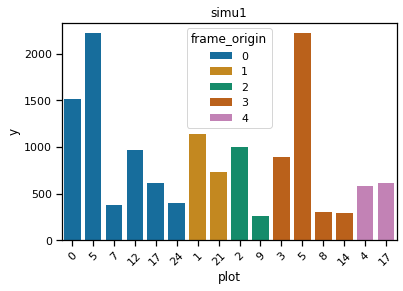

simu2


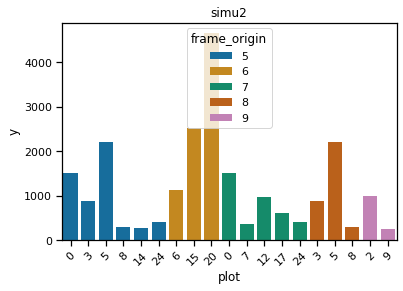

simu3


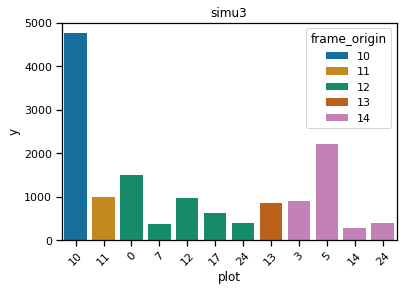

simu4


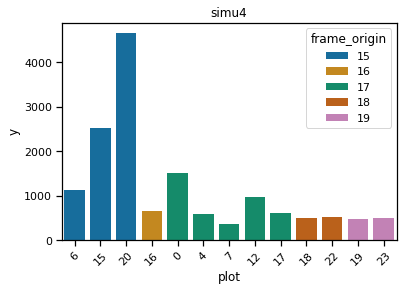

simu5


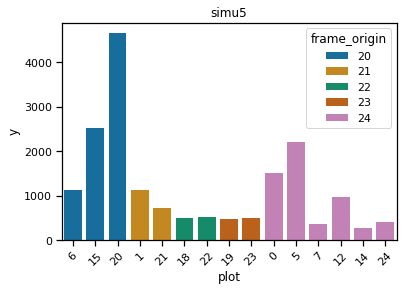

In [362]:
sns.set_context('notebook')
s = [x for x in df_2.sim]
s = sorted(list(set(s)))

for i in s:
    
    print(i)
    df_1 = df_2[df_2.sim == i]


    fig,ax = plt.subplots()

    sns.barplot(data=df_1,x='plot',y='y',hue='frame_origin',dodge=False,ax=ax)
    ax.set_xticks(ticks= ax.get_xticks(),labels=df_1.simil.values,rotation=45)
    ax.set_title(i)
    plt.show()


In [357]:
pop=[]

for key, value in dico.items():
    #print(key)
    #print(value[0])

    path='/Users/kansoali/Desktop/cg_simulations'
    os.chdir(path+os.sep+'new_' + key)

    x,y = np.loadtxt("clusters_size.xvg",comments=['#','@'],unpack=True) 
    res = [int(item) for item in y[:5]]
    
    pop.append(res)
    #print(value)
print(pop)
    
#pop

[[1514, 1138, 996, 894, 582], [2221, 1122, 376, 299, 256], [4765, 1002, 971, 848, 288], [2518, 667, 619, 499, 484], [4656, 728, 528, 501, 401]]


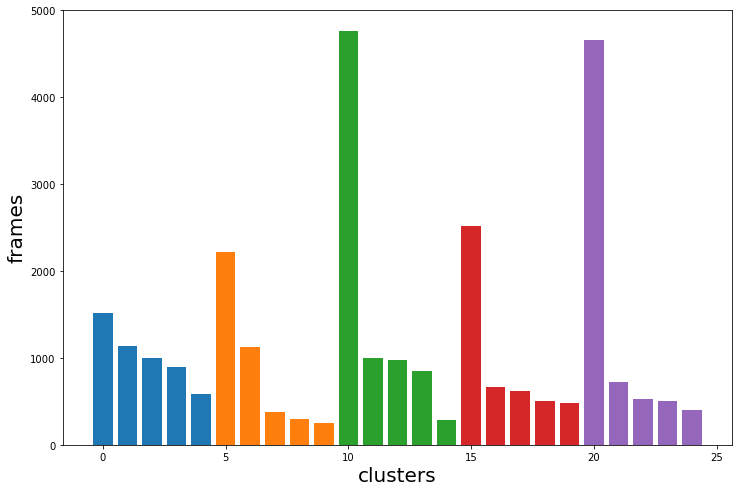

In [127]:
x1=list(range(0,5))
x2=list(range(5,10))
x3=list(range(10,15))
x4=list(range(15,20))
x5=list(range(20,25))

fig, ax = plt.subplots(figsize=(12,8))

plt.subplots_adjust(hspace=0.5)

#plt.xlim(0,26)

plt.bar(x1, pop[0])
plt.bar(x2, pop[1])
plt.bar(x3, pop[2])
plt.bar(x4, pop[3])
plt.bar(x5, pop[4])

plt.xlabel("clusters", fontsize=20)
plt.ylabel("frames",fontsize=20)
fig.show()

In [128]:
path='/Users/kansoali/Desktop/cg_simulations'

nb_simu=list(range(1,6))

for key, value in dico.items():
    if key == 'simu1':
        os.chdir(path+os.sep+'new_' + key)
        x,y = np.loadtxt("clusters_size.xvg",comments=['#','@'],unpack=True) 
        res = [int(item) for item in x[:5]]
        print(key)
        similar_frames0 = [x for x in value]
        print(similar_frames0)
    elif key == 'simu2':
        os.chdir(path+os.sep+'new_' + key)
        x,y = np.loadtxt("clusters_size.xvg",comments=['#','@'],unpack=True) 
        res = [int(item) for item in x[:5]]
        print(key)
        similar_frames1 = [x for x in value]
        print(similar_frames1)
    elif key == 'simu3':
        os.chdir(path+os.sep+'new_' + key)
        x,y = np.loadtxt("clusters_size.xvg",comments=['#','@'],unpack=True) 
        res = [int(item) for item in x[:5]]
        print(key)
        similar_frames2 = [x for x in value]
        print(similar_frames2)
    elif key == 'simu4':
        os.chdir(path+os.sep+'new_' + key)
        x,y = np.loadtxt("clusters_size.xvg",comments=['#','@'],unpack=True) 
        res = [int(item) for item in x[:5]]
        print(key)
        similar_frames3 = [x for x in value]
        print(similar_frames3)
    elif key == 'simu5':
        os.chdir(path+os.sep+'new_' + key)
        x,y = np.loadtxt("clusters_size.xvg",comments=['#','@'],unpack=True) 
        res = [int(item) for item in x[:5]]
        print(key)
        similar_frames4 = [x for x in value]
        print(similar_frames4)

simu1
[[0, 5, 7, 12, 17, 24], [1, 21], [2, 9], [3, 5, 8, 14], [4, 17]]
simu2
[[0, 3, 5, 8, 14, 24], [6, 15, 20], [0, 7, 12, 17, 24], [3, 5, 8], [2, 9]]
simu3
[[10], [11], [0, 7, 12, 17, 24], [13], [3, 5, 14, 24]]
simu4
[[6, 15, 20], [16], [0, 4, 7, 12, 17], [18, 22], [19, 23]]
simu5
[[6, 15, 20], [1, 21], [18, 22], [19, 23], [0, 5, 7, 12, 14, 24]]


In [119]:
population = [element for nestedlist in pop for element in nestedlist]  ## merge all pop in one list so i can get the index
similar_populations=[]

for x in range(26):
    if x in similar_frames0[0]:
        print(x)
        similar_populations.append(population[x])

0
5
7
12
17
24


In [120]:
print(similar_populations)

[1514, 2221, 376, 971, 619, 401]


In [122]:
similar_frames0[0]

[0, 5, 7, 12, 17, 24]

In [458]:
for i in dico['simu1']:
    print(i)

[0, 5, 7, 12, 17, 24]
[1, 21]
[2, 9]
[3, 5, 8, 14]
[4, 17]


In [ ]:
u=[]
for i in range (5):
    for x in simu1[i]:
        u.append(x)

In [ ]:
print(u)

In [ ]:
for x in u:
    if x<5:
        print ('cluster 1 of simu1 is similar to cluster(s):\n'+ str(x) +' in simu1')
    elif (x>9 and x<15):
        print (str(x-9) +' in simu2, ')
    elif (x>19 and x<25):
        print (str(x-19) +' in simu3')
    elif (x>29 and x<35):
        print (str(x-29) +' in simu4')
    elif (x>39 and x<45):
        #print(x-39)
        print (str(x-39) +" in simu5")

In [ ]:
#Save rmsd output to csv file

#df_rms.to_csv( fout_rms ,index_label='Time') 
#display(df_rms.head(5), df_rms.tail(4) )

#### **3. RMSF Analysis**
- HOWTO
    1. Prior to RMSF, the trajectory should be fitted to reference structure (`We have done it`)
    2. We obtain RMSF in different blocks (of 400 ns)
        - RMSF is usually computed for the whole trajectory
        - RMSF obtained in blocks (of 100 ns) gives more information.
            - Helps us to monitor RMSF changes at different time regimes
        - Save the RMSF data in dataframe (`df_rmsf`)
            - Herein, we use residue ids as index (row labels)

In [ ]:
fout_rmf   = 'RMSF.csv'  # rmsf output file
fout_pca   = 'PCA.csv'   # PCA projections
fout_cls   = 'CLUS.csv'  # Cluster output file

In [ ]:
# RMSF is calculated in blocks
nblocks = 10                                 #No. of blocks
size = U.trajectory.n_frames / nblocks       #Size of a block, 1000 frames
df_rmsf  = pd.DataFrame()   

size = int(size)
print( f"Number of frames in each block:{size}" )
print( f"Time region for each block:{df_rms.index[size]} ns\n")

# Here starts the rmsf estimation
for block in range(nblocks):
    
    # Start and End frames as obtained as intergers
    begin = (block * size) ;  end = (block + 1) * size
    print( f"Start frame:{begin} and End frame:{end}")
    
    # We use rms.RMSF routine to calculate the rmsf.
    brmsf = rms.RMSF( U.select_atoms(peptide), verbose=True ).run( start = begin , stop = end)
    df_rmsf[ f"B{block+1}" ]  =  brmsf.results.rmsf

print('Done Boss')

In [ ]:
# Extract residue numbers, keep them as row labels
Rids = U.select_atoms( peptide ).resnums  # resnums gives residue numbers for atmgroup Full
df_rmsf.index = Rids
df_rmsf.index.name = 'Residue' 

In [ ]:
# We can save the dataframe to output file

#df_rmsf.to_csv(fout_rmf ,index_label='Residue')
#display( df_rmsf.head(5),df_rmsf.tail(4))

#### **4. PCA Analysis**
- HOWTO
    1. PCA analysis is usually performed on a subset of atoms
        - Herein, we consider C$_\alpha$ atoms
    2. Since we have a longer trajectory, we use frames in 500 ps interval (0.5 ns)
        - Herein, we use begin, end, skip variables to define the range
    3. After applying PCA, we estimate statistical parameters
        - Cumulated variance
    4. We project the trajectory on PCA space
    5. We save projections on a dframe (`df_pca`)
        - We use `Time` signature as our dframe index

In [ ]:
from sklearn.decomposition import PCA
import hdbscan as HDBSCAN               #clustering algorithm

In [ ]:
# Selecting an atom group to apply PCA
sel = backbone
begin,end,skip = 0 , 10000 , 5

# PCA starts here
mypca = pca.PCA( U , select= sel )
mypca.run(begin,end,skip)
print('Done Boss')

In [ ]:
# Cumulated variance
# Infer number of PC components that explain most variance

display( f"Total number of PCs: {mypca.cumulated_variance.size} " )
print( f"Cumulative variance of first 10 PCs\n{ mypca.cumulated_variance[:9] } " )

In [ ]:
# Calculate projection for first 5 components

atmgrp =  U.select_atoms( sel ) ; ncomps = 9
pcspace = mypca.transform( atmgrp, n_components= ncomps, start = begin,stop = end,step = skip)

# Place the results in a dataframe
cols = [ f"PC{x+1}" for x in range(ncomps) ]
df_pca = pd.DataFrame( pcspace , columns= cols )
df_pca.head(5)

In [ ]:
# Add Time signatures to projection data
# We extract Time from df_rms data passing begin,end and skip values

df_pca['Time'] = df_rms.index[begin:end:skip]
df_pca.set_index('Time',inplace=True)

# Save the output to csv file
#df_pca.to_csv( fout_pca , index_label= 'Time' )
#display( df_pca.head(5) , df_pca.tail(4)  )

#### **View Motion along PCAs**
- For the first three PCs, firstly we identify,
    1. Min and Max projection values
    2. Time index and Frame number at which min and max happens
    3. Projected coordinates for the corresponding frames (`use get_motion` function)
    4. Use nglview to visualize the motion

In [ ]:
# 1. Min and max values for first three PCs
df_pca.iloc[:,:3].min() ,  df_pca.iloc[:,:3].max()

In [ ]:
# 2a Time @ which Min & Max values observed
allmin = df_pca.iloc[:,:3].idxmin(axis=0, skipna=True) 
allmax = df_pca.iloc[:,:3].idxmax(axis=0, skipna=True)
allmin,allmax

In [ ]:
# 2b Frame @ which Min & Max values observed
all_index = df_pca.index
for x,y in zip( allmin, allmax):
    print( f"min:{x} , max:{y}" )
    print( f"min-frame:{all_index.get_loc(x)} , max-frame:{all_index.get_loc(y)}\n" )  

#### **5. Cluster Analysis**
- HOWTO
    - There are many ways one may cluster the trajectory
      - Herein, we use the distribution of points on PCA space for clustering.
      - To this end, we use a density based clustering algorithm (hdbscan)
          - Note that density based methods identify also noise points that could not be assigned to any cluster.
    - Once the clusters are identified, we estimate
      - Distance of each point to the centroid of the cluster they belong to.
      - We extract the conformation close to centroid as `cluster representative`
    - Clustering results, as usual, are placed in a dframe ( `df_clus` )    

In [ ]:
# A cluster should have atleast 5% of total population

minsize = int( df_pca.shape[0]*.05)
print( f"Mininum samples in a cluster:{minsize}" )

# We use hdbscan library here (examine the Imports section at the top)
# We use PCs 1-5

hdbs = HDBSCAN.HDBSCAN(min_cluster_size=minsize)
hclus = hdbs.fit_predict(df_pca.loc[:,'PC1':'PC10'] )

# Obtain total number of clusters
Nclus = set(hclus)
display( f'No of clusters: { len( Nclus ) } and cluster ids: {Nclus} ')

In [ ]:
# Create dframe to store cluster results
df_clus = pd.DataFrame( )

# Assign clusters and time index
df_clus['Cluster' ] = hclus
df_clus.index.name = 'Time'
df_clus.index = df_pca.index

display( df_clus.head(5),df_clus.tail(4) )

In [ ]:
# We extract RMSD values for frame in each cluster
df_rms.iloc[ begin:end:skip ].full

In [ ]:
# Add RMSD to cluster data
df_clus[ 'RMSD' ] =  df_rms.iloc[ begin:end:skip ].full

In [ ]:
display( df_clus.head(5),df_clus.tail(2) )

In [ ]:
# First, we assign CDist as a column with value 0
df_clus['CDist'] = 0.0

# For each point, we obtain its distance to the centroid

for val in Nclus:
    print(f"Current cluster id:{val}")
    # Extract subset of dframe corresponding to the cluster id
    subset = df_clus[df_clus.Cluster == val].index
    points = df_pca.loc[ subset, "PC1":"PC3" ].values
    Mean   = points.mean(axis=0)
    
    # Distance to cluster centroid (i.e mean value)
    dist = np.sqrt( ( (points - Mean)**2 ).sum(1)  )
    df_clus.loc[ subset, 'CDist'] = dist
                
df_clus.head()

In [ ]:
# Collect as Time values in df_rms
Frame = df_rms.index

# For each Time information df_clus, collect corresponding frame number from df_rms
Frame_no = [ Frame.get_loc(x) for x in df_clus.index ]

# Add Frame number as new column in the cluster data
df_clus['FRAME'] = Frame_no

#df_clus.to_csv( fout_cls , index_label= 'Time')
df_clus.head(4)

In [ ]:
# For each cluster, identify point closer to centroid (i.e, Min of CDist)
print(df_clus.groupby(['Cluster']).min() )
Mns = df_clus.groupby(['Cluster']).min().CDist

In [ ]:
# Structure closer to centroid can be considered as representatives
# Identify frame no of representatives
df_clus[ df_clus.CDist.isin(Mns) ]

- **Attension**
    1. In density based clustering `-1` represents noise points in space.
        - We are not interested in the representatives of noise points.
    2. We know the `Time` signature and `Frame no` of the representatives
        - Hence, we save the representatives as pdb's

In [ ]:
# Cluster -1 is noise, so we ignore it

Sel = U.select_atoms('protein')
U.trajectory[2035]
Sel.write('C1.pdb')

U.trajectory[7735]
Sel.write('C2.pdb')

#U.trajectory[4955]
#Sel.write('C3.pdb')

## DATA VISUALIZATION

#### **RMSD**

#### **RMSF**

In [ ]:
df_rmsf.boxplot() 

In [ ]:
rmsf_m1 = df_rmsf.loc[ : , 'B1':'B10'].mean(axis=1)
#rmsf_m2 = df_rmsf.loc[ : , 'B4':'B7'].mean(axis=1)
#rmsf_m3 = df_rmsf.loc[ : , 'B7':'B10'].mean(axis=1)

rmsf_m1.plot()
#rmsf_m2.plot()
#rmsf_m3.plot()

plt.xlim([367,372])
# Highlight NBD
#plt.axvspan(40,155,color='k',alpha=0.2)
#plt.axvspan(157,265,color='g',alpha=0.1)
#plt.axvspan(267,375,color='y',alpha=0.1)
#plt.axvspan(342,373,color='R',alpha=0.1)

#plt.text(80,15,'D1',size=16)
#plt.text(200,15,'D2',size=16)
#plt.text(300,15,'D3',size=16)
#plt.text(315,15,'D4',size=16)
plt.ylabel('RMSF $\AA$')

#### **PCA**

In [ ]:
# Visualize cumulative variance of first 10 PCs
fig, ax = plt.subplots( figsize=(4.5,3.2) )
Y = mypca.cumulated_variance[:10]
X = [ l+1 for l in range(10) ]
ax.plot( X, Y ,'s--' ,ms=5)
ax.axhline( Y[2], color='b' , ls='--' )
ax.set_ylabel('Explained Variance (%)')
ax.set_xlabel('PC index')

In [ ]:
# We visualize the scatter plots for most prominent (PC1-3)
# Make scatter plots of PCs1-3
fig, ax = plt.subplots(1,2,figsize=(10,4),dpi=300 )
fig.subplots_adjust( wspace = 0.32)

sns.scatterplot(data=df_pca,x="PC1",y="PC2",ax=ax[0])
sns.scatterplot(data=df_pca,x="PC1",y="PC3",ax=ax[1])


# Seaborn color maps (https://seaborn.pydata.org/tutorial/color_palettes.html)

#sns.kdeplot(data=df_pca,x="PC1",y="PC2",ax=ax[0],shade=True,cmap='Greys_r')
#sns.kdeplot(data=df_pca,x="PC1",y="PC3",ax=ax[1],shade=True,cmap='Set1')


In [ ]:
# Distribution along individual PC components
sns.distplot(df_pca.PC1,label='PC1',hist=False)
sns.distplot(df_pca.PC2,label='PC2',hist=False)
sns.distplot(df_pca.PC4,label='PC4',hist=False)
sns.distplot(df_pca.PC5,label='PC5',hist=False)

plt.legend()  #Explained Variance reduces as we go from PC1 to PC5
plt.xlim([-100,100])
sns.set(rc={'figure.figsize':(10,4)})

#### **Cluster Evolution**


In [ ]:
# Lets map clusters on RMSD plot
nclus = set( df_clus.Cluster)
fig, ax = plt.subplots( figsize=(10,8) )

for val in nclus:
    # val -1 indicates noise points
    # For each cluster, we show frame closer to cluster centroid as Cross
    if val > -1:
        data = df_clus[ df_clus.Cluster == val ]
        ax.plot( data.index,data.RMSD,'.')
        
        Mn = data.CDist.min()
        Cent =  data[ data.CDist == Mn ]
        ax.plot( Cent.index, Cent.RMSD, 'X',color='green',ms=16)
            

ax.set_xlabel('Time ns')
ax.set_ylabel('RMSD $\AA$')

In [ ]:
# Lets view the Cluster representatives
r1 = mda.Universe( 'C1.pdb' )
r2 = mda.Universe( 'C2.pdb' )
#r3 = mda.Universe( 'C3.pdb' )

view = nv.show_mdanalysis(r1)
view.add_trajectory( r2 )
#view.add_trajectory( r3 )

view[0].clear_representations()
view[0].add_cartoon(color='blue')
view[1].clear_representations()
view[1].add_cartoon(color='yellow')


#view[2].clear_representations()
#view[2].add_cartoon(color='cyan')

#view.display(gui=True)
#show_residues_around(view,selection="367",radius=4.0)
view

#### **Inference:**